# Pytorch Transformers from Scratch (Attention is all you need)

 

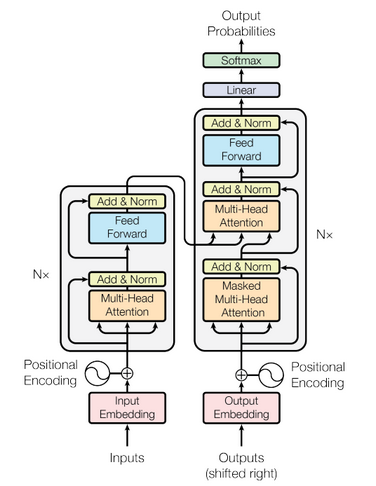

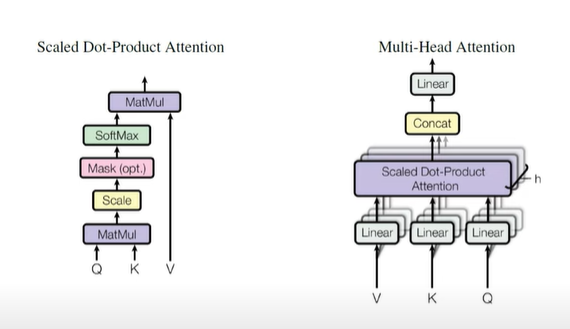

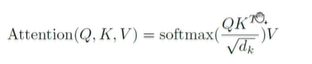

In [33]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):

  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads

    assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


  def forward(self, values, keys, queires, mask):
    N = queires.shape[0] # how many sample we send in at the same time
    value_len, key_len, query_len = values.shape[1], keys.shape[1], queires.shape[1] 

    # Split embedding into self.heads pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, value_len, self.heads, self.head_dim)
    queires = queires.reshape(N, value_len, self.heads, self.head_dim)

    energy = torch.einsum("nqhd, nkhd->nhqk", [queires, keys])
    # quires shape: (N, query_len, heads, head_dim)
    # keys shape: (N, key_len, heads, head_dim)
    # energy shape: (N, heads, query_len, key_len)

    if mask is not None:
      energy = energy.masked_fill(mask==0, float("-1e20"))

    attention = torch.softmax(energy / (self.embed_size **(1/2)), dim=3)

    out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(
        N, query_len, self.heads*self.head_dim
    )
    # attention shape (N, heads, query_len, key_len)
    # value shape (N, value_len, heads, heads_dim)
    # after einsum (N, query_len, heads, head_dim) then flatten last two dimentions

    out = self.fc_out(out)

    return out 

  
class TransformerBlock(nn.Module):

  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)

    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, value, key, query, mask):
    attentioin = self.attention(value, key, query, mask)

    x = self.dropout(self.norm1(attentioin + query))
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out

class EncoderBlock(nn.Module):
  
  def __init__(
      self,
      src_vocal_size,
      embed_size,
      num_layers,
      heads,
      devices,
      forward_expension,
      dropout,
      max_length,
  ):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocal_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
         TransformerBlock(
             embed_size,
             heads,
             dropout=dropout,
             forward_expension=forward_expension
         )
        ]
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_lenght = x.shape

    # the position will be (0, 1, 2, 3, ......)
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    out = self.word_embedding(x) + self.position_embedding(positions)

    for layer in self.layers:
      out = layer(out, out, out, mask)

    return out


class DecoderBlock(nn.Module):
  def __init__(self,
      embed_size,
      heads,
      forward_expension,
      dropout,
      device):
    super(DecoderBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = TransformerBlock(
        embed_size, heads, dropout, forward_expension
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, trg_mask):
    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out 


class Encoder(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length
  ):
    super(Encoder, self).__init__()
    self.device = device
    self.embed_size = embed_size
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
          TransformerBlock(
            embed_size,
            heads,
            dropout=dropout,
            forward_expansion=forward_expansion
          )
        ]
    )

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_lenght = x.shape
    positions = torch.arange(0, seq_lenght).expand(N, seq_lenght).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)

    return out

class Decoder(nn.Module):
  def __init__(
      self,
      trg_vocab_size,
      embed_size,
      num_layers,
      heads,
      forward_expension,
      dropout,
      device,
      max_lenght,
  ):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_lenght, embed_size)

    self.layers = nn.ModuleList(
        [DecoderBlock(
            embed_size,
            heads,
            forward_expension,
            dropout, 
            device
        ) for _ in range(num_layers)]
    )

    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(x)


class Transformer(nn.Module):

  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=256,
      num_layers=6,
      forward_expension=4,
      heads=8,
      dropout = 0,
      device="cpu",
      max_lenght = 100
  ):
    super(Transformer, self).__init__()

    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expension,
        dropout,
        max_lenght
    )

    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expension,
        dropout,
        device,
        max_lenght
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # (N, 1, 1, src_len)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)    

  def forward(self, src, trg):
    src_mask = self.make_trg_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out

if __name__ == "__main__":

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0],
             [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
  
  trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 1, 0], [1, 5, 6, 2, 4, 7, 6, 2, 0]]).to(device)

  src_pad_idx = 0
  trg_pad_idx = 0 
  src_vocab_size = 10
  trg_vocab_size = 10

  model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
  out = model(x, trg[:, :-1])
  print(out.shape)




RuntimeError: ignored